In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, nbinom
from scipy.special import logsumexp
from statsmodels.tsa.stattools import acf
from utils.plots import (
    plot_time_series,
    plot_histogram_h,
    plot_acf_h,
    plot_acf_y,
    plot_scatter_y_h,
    plot_overlay_clean,
)
import math
from numba import njit
import time 


## Seeing the impact of the choice of Z.

In [12]:
class CoxProcessSimulation:
    def __init__(self, T, phi, nu, c):
        self.T = T
        self.phi = phi
        self.nu = nu
        self.c = c
                                            
    def simulate(self):
        h = np.zeros(self.T)
        y = np.zeros(self.T, dtype=int)
        z = np.zeros(self.T, dtype=int)
        h[0] = np.random.gamma(self.nu, self.c/(1-self.phi))
        y[0] = np.random.poisson(h[0])
        
        for t in range(1, self.T):
            lambda_z = (self.phi * h[t-1]) / self.c
            z[t] = np.random.poisson(lambda_z)
            h[t] = np.random.gamma(self.nu + z[t], self.c)
            y[t] = np.random.poisson(h[t])
            
        return y, h, z

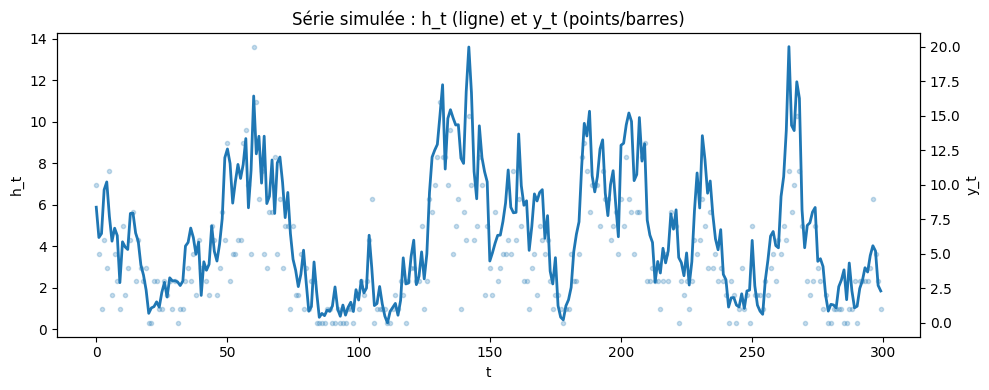

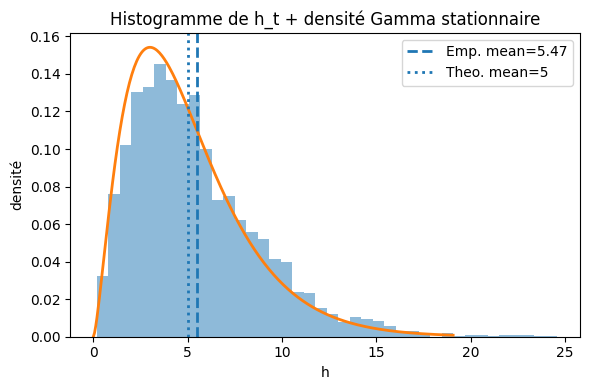

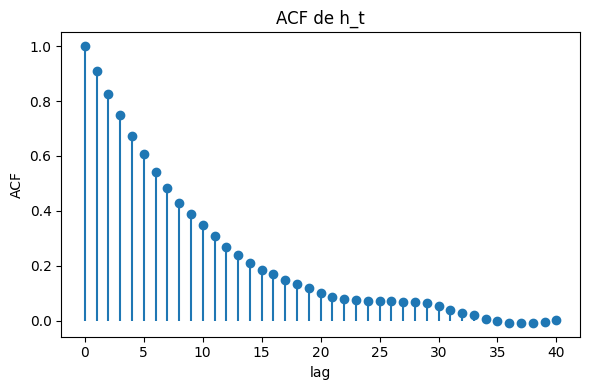

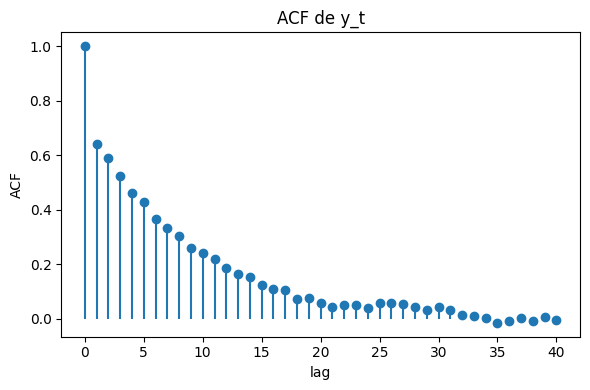

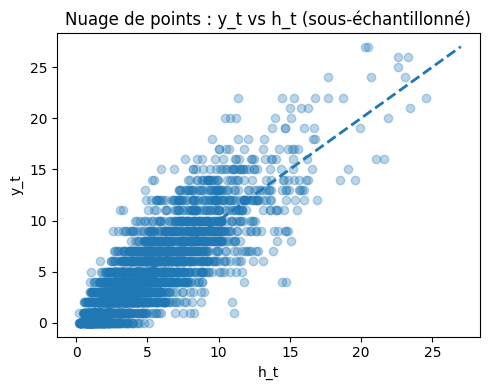

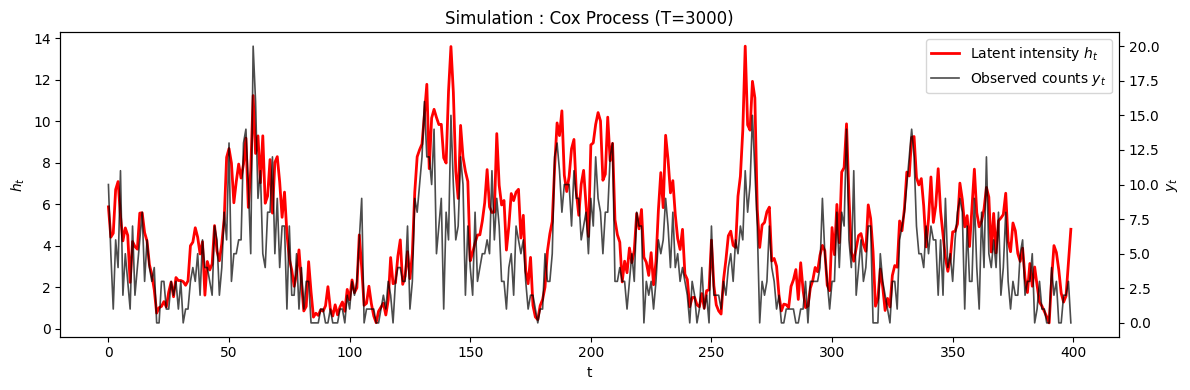

In [13]:
TRUE_PARAMS = {'phi': 0.9, 'nu': 2.5, 'c': 0.2}
T_sim = 3000

sim = CoxProcessSimulation(T=T_sim, **TRUE_PARAMS)
y, h, z = sim.simulate()

plot_time_series(y, h, T_show=300, start=0, use_bars=False)
plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
plot_acf_h(h, lags=40, burn=200)
plot_acf_y(y, lags=40, burn=200)
plot_scatter_y_h(y, h, max_points=3000)
plot_overlay_clean(y, h, T_show=400, start=0)



In [14]:
# ==========================
# Numba helpers
# ==========================
@njit
def _logsumexp_1d(a):
    m = -1e300
    for i in range(a.shape[0]):
        if a[i] > m:
            m = a[i]
    s = 0.0
    for i in range(a.shape[0]):
        s += math.exp(a[i] - m)
    return m + math.log(s)


@njit
def _nbinom_logpmf(k, r, p):
    """
    SciPy-like NB parameterization:
    P(K=k) where k is #failures before r successes, success prob p.
    log pmf = lgamma(k+r) - lgamma(r) - lgamma(k+1) + r log p + k log(1-p)
    """
    return (math.lgamma(k + r) - math.lgamma(r) - math.lgamma(k + 1.0)
            + r * math.log(p) + k * math.log(1.0 - p))


@njit
def _exact_filter_loglik(y, Z, phi, nu, c):
    """
    Returns:
      total_log_like, max_pZ
    where max_pZ = max_t P(z_t=Z | y_1:t)
    """
    T = y.shape[0]
    z_grid = np.arange(Z + 1)

    # Init: z1 ~ NegBin(r=nu, p=1-phi)
    log_p_z = np.empty(Z + 1)
    p_init = 1.0 - phi
    for i in range(Z + 1):
        log_p_z[i] = _nbinom_logpmf(z_grid[i], nu, p_init)

    p_obs = 1.0 / (1.0 + c)
    p_trans = (1.0 + c) / (1.0 + c + phi)

    total_log_like = 0.0
    tmp = np.empty(Z + 1)
    new_log_p_z = np.empty(Z + 1)

    max_pZ = 0.0  # diagnostic: max_t P(z_t=Z | y_1:t)

    for t in range(T):
        yt = y[t]

        # 1) Update with observation
        for i in range(Z + 1):
            r_obs = nu + z_grid[i]
            tmp[i] = _nbinom_logpmf(yt, r_obs, p_obs) + log_p_z[i]

        log_like_t = _logsumexp_1d(tmp)
        total_log_like += log_like_t

        # Normalize log p(z_t | y_1:t)
        for i in range(Z + 1):
            log_p_z[i] = tmp[i] - log_like_t

        # ---- diagnostic mass at boundary Z ----
        pZ = math.exp(log_p_z[Z])  # P(z_t=Z | y_1:t)
        if pZ > max_pZ:
            max_pZ = pZ

        # 2) Prediction
        if t < T - 1:
            y_prev = yt

            for j in range(Z + 1):
                m = -1e300
                for i in range(Z + 1):
                    r_trans = nu + y_prev + z_grid[i]
                    val = _nbinom_logpmf(z_grid[j], r_trans, p_trans) + log_p_z[i]
                    if val > m:
                        m = val
                s = 0.0
                for i in range(Z + 1):
                    r_trans = nu + y_prev + z_grid[i]
                    val = _nbinom_logpmf(z_grid[j], r_trans, p_trans) + log_p_z[i]
                    s += math.exp(val - m)
                new_log_p_z[j] = m + math.log(s)

            for j in range(Z + 1):
                log_p_z[j] = new_log_p_z[j]

    return total_log_like, max_pZ



class ExactFilter:
    """
    Fast (Numba-compiled) exact likelihood filter for the Poisson-Gamma count model,
    truncated to z in {0,...,Z_trunc}.

    Usage:
        f = ExactFilter(y, Z_trunc=2000)
        ll = f.log_likelihood(phi=0.95, nu=2.5, c=0.2)

    Notes:
        - 1st call triggers Numba compilation (slow), next calls are fast.
        - Constraints: 0<phi<1, nu>1, c>0.
    """
    def __init__(self, y, Z_trunc=50):
        self.y = np.asarray(y, dtype=np.int64)
        if self.y.ndim != 1:
            raise ValueError("y must be a 1D array of counts.")
        if np.any(self.y < 0):
            raise ValueError("y must contain nonnegative counts.")
        self.T = self.y.shape[0]
        self.Z = int(Z_trunc)
        if self.Z < 0:
            raise ValueError("Z_trunc must be >= 0.")

    def log_likelihood(self, phi, nu, c, return_diag=False):
        phi = float(phi)
        nu = float(nu)
        c = float(c)

        # Basic constraints (paper uses nu>1 for Feller + stationarity phi<1)
        if not (0.0 < phi < 1.0):
            raise ValueError("phi must satisfy 0 < phi < 1.")
        if not (nu > 1.0):
            raise ValueError("nu must be > 1 (Feller condition).")
        if not (c > 0.0):
            raise ValueError("c must be > 0.")

        ll, max_pZ = _exact_filter_loglik(self.y, self.Z, phi, nu, c)
        if return_diag:
            return ll, max_pZ
        return ll


In [15]:
Z_list = [20, 30, 40, 50, 75, 100, 200, 400, 800]

loglikes = []
times = []
max_pZ_list = []

phi, nu, c = 0.9, 2.5, 0.2

for Z in Z_list:
    f = ExactFilter(y, Z_trunc=Z)

    t0 = time.time()
    ll, max_pZ = f.log_likelihood(phi=phi, nu=nu, c=c, return_diag=True)
    t1 = time.time()

    loglikes.append(ll)
    times.append(t1 - t0)
    max_pZ_list.append(max_pZ)

    print(
        f"Z={Z:4d} | log-like={ll:10.2f} | "
        f"time={t1-t0:6.2f}s | max P(z=Z|y)={max_pZ:.2e}"
    )


Z=  20 | log-like= -10595.20 | time=  1.11s | max P(z=Z|y)=6.30e-01
Z=  30 | log-like=  -8627.60 | time=  0.32s | max P(z=Z|y)=4.82e-01
Z=  40 | log-like=  -7795.34 | time=  0.56s | max P(z=Z|y)=3.68e-01
Z=  50 | log-like=  -7434.29 | time=  0.85s | max P(z=Z|y)=2.81e-01
Z=  75 | log-like=  -7192.33 | time=  2.01s | max P(z=Z|y)=1.33e-01
Z= 100 | log-like=  -7161.28 | time=  3.40s | max P(z=Z|y)=4.75e-02
Z= 200 | log-like=  -7156.24 | time= 13.46s | max P(z=Z|y)=1.51e-09
Z= 400 | log-like=  -7156.24 | time= 53.11s | max P(z=Z|y)=2.31e-36
Z= 800 | log-like=  -7156.24 | time=211.25s | max P(z=Z|y)=6.48e-83


In [21]:
# Référence
ll_ref = loglikes[-1]

# DataFrame
results = pd.DataFrame({
    "Z": Z_list,
    "log_likelihood": loglikes,
    "Diff_logL_vs_Zmax": [ll - ll_ref for ll in loglikes],
    "time_sec": times,
    "max_P_z_eq_Z": max_pZ_list
})

# Enregistrement en CSV
results.to_csv("results_Z_truncation.csv", index=False)
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-10595.200738,-3.438964e+03,1.112186,6.301456e-01
1,30,-8627.598978,-1.471363e+03,0.320307,4.816051e-01
2,40,-7795.342074,-6.391056e+02,0.558972,3.684628e-01
3,50,-7434.289682,-2.780533e+02,0.851948,2.809042e-01
4,75,-7192.332131,-3.609570e+01,2.005003,1.332874e-01
5,100,-7161.275472,-5.039046e+00,3.401654,4.745687e-02
6,200,-7156.236426,-2.535671e-09,13.461245,1.509214e-09
7,400,-7156.236426,0.000000e+00,53.107023,2.309351e-36
8,800,-7156.236426,0.000000e+00,211.248106,6.477343e-83


In [22]:
results = pd.read_csv("results_Z_truncation.csv")
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-10595.200738,-3.438964e+03,1.112186,6.301456e-01
1,30,-8627.598978,-1.471363e+03,0.320307,4.816051e-01
2,40,-7795.342074,-6.391056e+02,0.558972,3.684628e-01
3,50,-7434.289682,-2.780533e+02,0.851948,2.809042e-01
4,75,-7192.332131,-3.609570e+01,2.005003,1.332874e-01
5,100,-7161.275472,-5.039046e+00,3.401654,4.745687e-02
6,200,-7156.236426,-2.535671e-09,13.461245,1.509214e-09
7,400,-7156.236426,0.000000e+00,53.107023,2.309351e-36
8,800,-7156.236426,0.000000e+00,211.248106,6.477343e-83


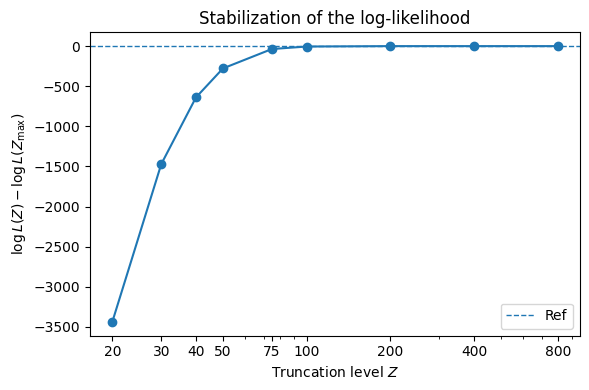

In [24]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["Diff_logL_vs_Zmax"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1, label=r"Ref")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$")
plt.ylabel(r"$\log L(Z) - \log L(Z_{\max})$")
plt.title("Stabilization of the log-likelihood")
plt.legend()
plt.tight_layout()
plt.show()


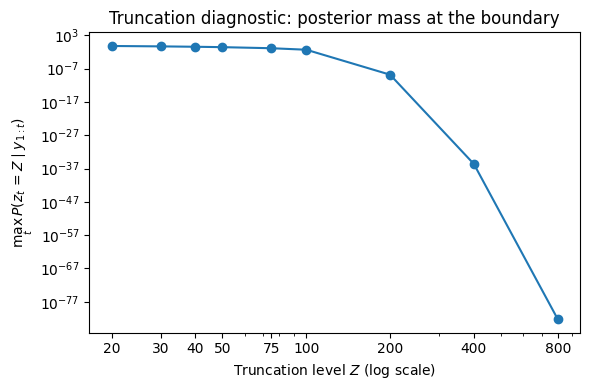

In [25]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["max_P_z_eq_Z"], marker="o")

plt.xscale("log")
plt.yscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel(r"$\max_t\, P(z_t = Z \mid y_{1:t})$")
plt.title("Truncation diagnostic: posterior mass at the boundary")
plt.tight_layout()
plt.show()


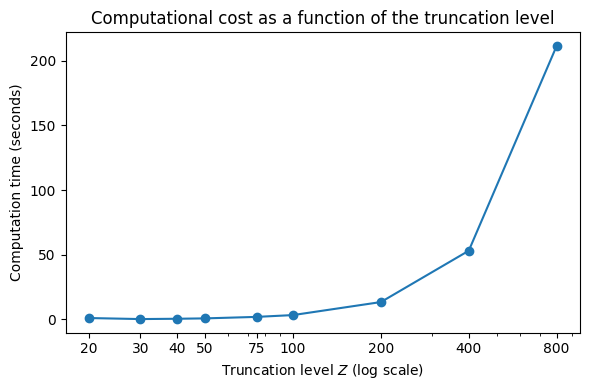

In [26]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["time_sec"], marker="o")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel("Computation time (seconds)")
plt.title("Computational cost as a function of the truncation level")
plt.tight_layout()
plt.show()


## Comparaison avec un particle filter 

In [5]:
import math
from numba import njit
from scipy.special import gammaln


# ======================================================
# Systematic resampling (Numba, O(N))
# ======================================================
@njit
def _systematic_resample_idx(w):
    N = w.shape[0]
    idx = np.empty(N, dtype=np.int64)

    cdf = np.empty(N)
    s = 0.0
    for i in range(N):
        s += w[i]
        cdf[i] = s
    cdf[N - 1] = 1.0  # sécurité numérique

    u0 = np.random.random() / N
    j = 0
    for i in range(N):
        u = u0 + i / N
        while u > cdf[j]:
            j += 1
        idx[i] = j

    return idx


# ======================================================
# Core PF (Numba)
# ======================================================
@njit
def _pf_loglik_numba(y, logfact, N, phi, nu, c, ess_ratio):
    T = y.shape[0]

    # Init stationnaire
    h = np.random.gamma(nu, c / (1.0 - phi), N)

    h_new = np.empty(N)
    w = np.empty(N)

    total_ll = 0.0
    logN = math.log(N)

    for t in range(T):
        yt = y[t]

        # ----------------------
        # 1) Propagation
        # ----------------------
        for i in range(N):
            lam = (phi * h[i]) / c
            z = np.random.poisson(lam)
            h_new[i] = np.random.gamma(nu + z, c)

        # ----------------------
        # 2) Weighting
        # log p(y_t | h_t) = y log h - h - log(y!)
        # ----------------------
        m = -1e300
        for i in range(N):
            hi = h_new[i]
            lw = yt * math.log(hi) - hi - logfact[t]
            w[i] = lw
            if lw > m:
                m = lw

        # log predictive likelihood
        s = 0.0
        for i in range(N):
            s += math.exp(w[i] - m)
        total_ll += (m + math.log(s) - logN)

        # normalize weights
        inv_s = 1.0 / s
        for i in range(N):
            w[i] = math.exp(w[i] - m) * inv_s

        # ----------------------
        # 3) ESS + resampling
        # ----------------------
        ssq = 0.0
        for i in range(N):
            ssq += w[i] * w[i]
        ess = 1.0 / ssq

        if ess < ess_ratio * N:
            idx = _systematic_resample_idx(w)
            for i in range(N):
                h[i] = h_new[idx[i]]
        else:
            for i in range(N):
                h[i] = h_new[i]

    return total_ll


# ======================================================
# User-facing class
# ======================================================
class ParticleFilterIdeal:
    """
    Ideal bootstrap particle filter for the Poisson–Gamma Cox model.

    - Numba-accelerated
    - Systematic resampling
    - ESS-adaptive
    - Reproducible via seed
    """

    def __init__(self, y, N_particles=1000, ess_ratio=0.5):
        self.y = np.asarray(y, dtype=np.int64)
        if self.y.ndim != 1 or np.any(self.y < 0):
            raise ValueError("y must be a 1D array of nonnegative counts.")

        self.N = int(N_particles)
        self.ess_ratio = float(ess_ratio)

        # precompute log(y!)
        self.logfact = gammaln(self.y + 1.0).astype(np.float64)

    def log_likelihood(self, phi, nu, c, seed=123):
        phi = float(phi)
        nu = float(nu)
        c = float(c)

        if not (0.0 < phi < 1.0):
            raise ValueError("phi must satisfy 0 < phi < 1.")
        if not (nu > 0.0):
            raise ValueError("nu must be > 0.")
        if not (c > 0.0):
            raise ValueError("c must be > 0.")

        # seed for reproducibility
        np.random.seed(seed)

        return _pf_loglik_numba(
            self.y,
            self.logfact,
            self.N,
            phi,
            nu,
            c,
            self.ess_ratio
        )


## Test case simple 

In [6]:
phi_grid = np.linspace(0.7, 0.95, 50)


In [10]:
exact_filter = ExactFilter(y, Z_trunc=100)
particle_filter = ParticleFilterIdeal(y, N_particles=5000)

ll_exact = []
ll_pf = []

for p in phi_grid:
    ll_exact.append(
        exact_filter.log_likelihood(phi=p, nu=TRUE_PARAMS["nu"], c=TRUE_PARAMS["c"])
    )

    ll_pf.append(
        particle_filter.log_likelihood(phi=p, nu=TRUE_PARAMS["nu"], c=TRUE_PARAMS["c"], seed=0)
    )


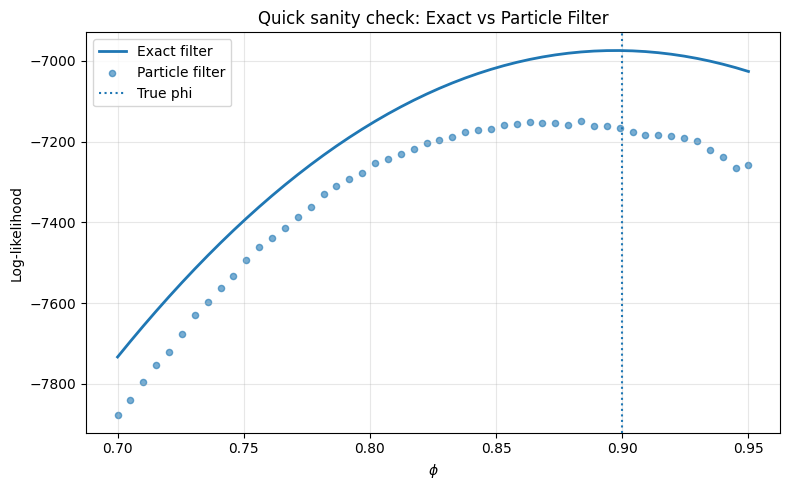

In [11]:
plt.figure(figsize=(8,5))

plt.plot(phi_grid, ll_exact, label="Exact filter", linewidth=2)
plt.scatter(phi_grid, ll_pf, label="Particle filter", s=20, alpha=0.6)

plt.axvline(TRUE_PARAMS["phi"], linestyle=":", label="True phi")

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Quick sanity check: Exact vs Particle Filter")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Test case with more value

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# -----------------------------
# Assumptions:
# - exact_filter = ExactFilter(y_obs, Z_trunc=...)
# - ParticleFilterIdeal(y_obs, N_particles=...) exists
# - TRUE_PARAMS dict exists with keys "phi", "nu", "c"
# - y_obs is your observed series
# -----------------------------

nu = TRUE_PARAMS["nu"]
c = TRUE_PARAMS["c"]

exact_filter = ExactFilter(y, Z_trunc=100)

# ============================================================
# Helper: compute PF likelihood profile for ONE seed (parallel)
# ============================================================
def pf_profile_for_seed(y_obs, N_particles, phi_grid, nu, c, seed, ess_ratio=0.5):
    pf = ParticleFilterIdeal(y_obs, N_particles=N_particles, ess_ratio=ess_ratio)
    out = np.empty(len(phi_grid), dtype=np.float64)
    for j, p in enumerate(phi_grid):
        out[j] = pf.log_likelihood(phi=p, nu=nu, c=c, seed=int(seed))
    return out


/opt/python/lib/python3.13/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Figure 1: PF cloud:   0%|          | 0/5 [01:58<?, ?it/s]


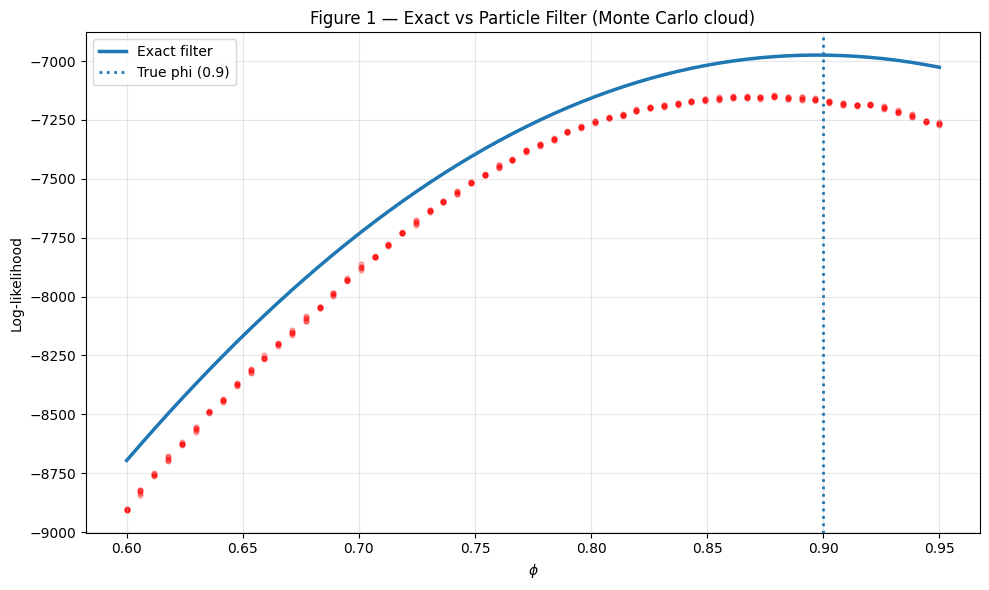

In [ ]:
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

# =========================
# FIGURE 1: Cloud (fast)
# =========================
phi_grid_cloud = np.linspace(0.6, 0.95, 60)
seeds_cloud = np.arange(5)
N_cloud = 3000
ess_ratio = 0.5

# exact on the same grid
ll_exact_cloud = np.array([
    exact_filter.log_likelihood(phi=p, nu=nu, c=c)
    for p in phi_grid_cloud
])

# PF runs in parallel WITH progress bar
with tqdm_joblib(
    tqdm(desc="Figure 1: PF cloud", total=len(seeds_cloud))
):
    ll_pf_cloud_runs = np.array(
        Parallel(n_jobs=-1, prefer="processes")(
            delayed(pf_profile_for_seed)(
                y, N_cloud, phi_grid_cloud, nu, c, int(seed), ess_ratio
            )
            for seed in seeds_cloud
        )
    )

# Plot cloud
plt.figure(figsize=(10, 6))
plt.plot(phi_grid_cloud, ll_exact_cloud, linewidth=2.5, label="Exact filter")

for r in range(ll_pf_cloud_runs.shape[0]):
    plt.scatter(phi_grid_cloud, ll_pf_cloud_runs[r],
                s=12, alpha=0.30, color="red")

plt.axvline(TRUE_PARAMS["phi"], linestyle=":", linewidth=2,
            label=f"True phi ({TRUE_PARAMS['phi']})")

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Figure 1 — Exact vs Particle Filter (Monte Carlo cloud)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/opt/python/lib/python3.13/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 30/30 [08:29<00:00, 17.00s/it] | 0/30 [00:00<?, ?it/s]


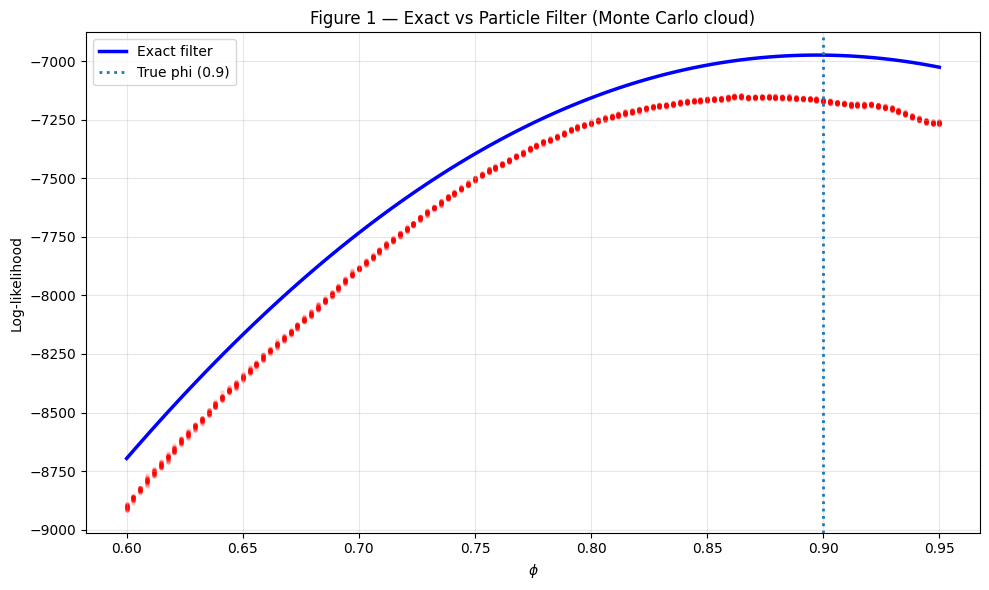

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# =========================
# FIGURE 1: Cloud (Creal-like)
# =========================
phi_grid_cloud = np.linspace(0.6, 0.95, 120)   # plus fin qu'avant
seeds_cloud = np.arange(30)                    # plus de runs -> nuage dense
N_cloud = 3000
ess_ratio = 0.5

# exact on the same grid
ll_exact_cloud = np.array([
    exact_filter.log_likelihood(phi=p, nu=nu, c=c)
    for p in phi_grid_cloud
])

def pf_profile_for_seed_local(seed):
    # pf_profile_for_seed(y, N_particles, phi_grid, nu, c, seed, ess_ratio)
    return pf_profile_for_seed(y, N_cloud, phi_grid_cloud, nu, c, int(seed), ess_ratio)

# PF runs in parallel with progress bar
with tqdm_joblib(tqdm(desc="Figure 1: PF cloud (Creal-like)", total=len(seeds_cloud))):
    ll_pf_cloud_runs = np.array(
        Parallel(n_jobs=-1, prefer="processes")(
            delayed(pf_profile_for_seed_local)(seed) for seed in seeds_cloud
        )
    )

# ---- Plot cloud
plt.figure(figsize=(10, 6))

# exact curve
plt.plot(phi_grid_cloud, ll_exact_cloud, linewidth=2.5, color="blue", label="Exact filter")

# cloud: all PF realizations
for r in range(ll_pf_cloud_runs.shape[0]):
    plt.scatter(phi_grid_cloud, ll_pf_cloud_runs[r],
                s=6, alpha=0.12, color="red")

plt.axvline(TRUE_PARAMS["phi"], linestyle=":", linewidth=2,
            label=f"True phi ({TRUE_PARAMS['phi']})")

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Figure 1 — Exact vs Particle Filter (Monte Carlo cloud)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Optionnel: zoom autour du maximum (style papier)
# plt.xlim(0.85, 0.95)

plt.show()


In [8]:
v1 = particle_filter.log_likelihood(phi=0.85, nu=nu, c=c, seed=0)
v2 = particle_filter.log_likelihood(phi=0.85, nu=nu, c=c, seed=1)
print(v1, v2, v2-v1)


NameError: name 'particle_filter' is not defined

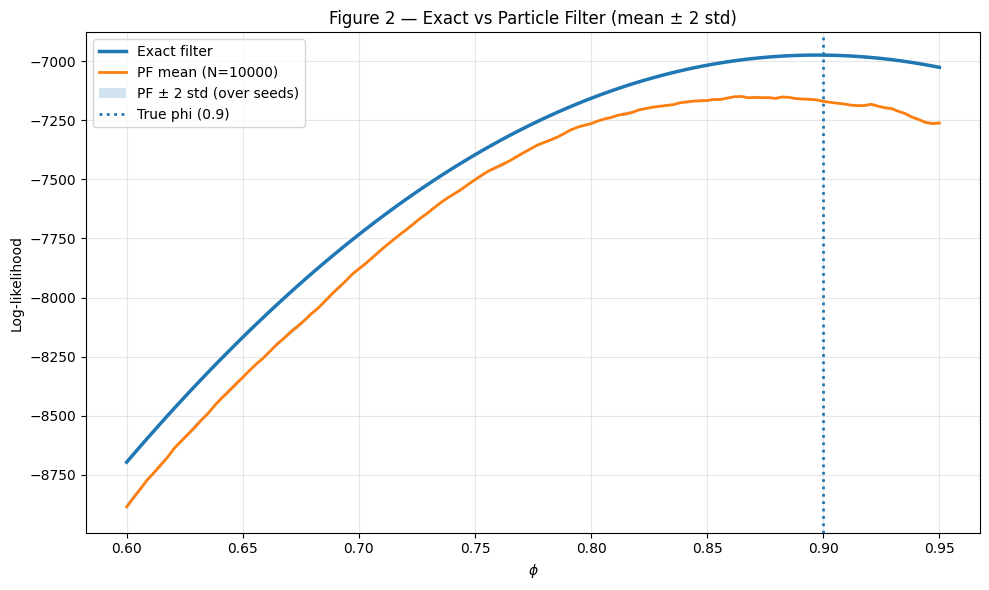

In [9]:
# ==============================
# FIGURE 2: Mean + uncertainty
# ==============================
phi_grid_mean = np.linspace(0.6, 0.95, 120)
seeds_mean = np.arange(10)
N_mean = 10000

# exact on the mean grid
ll_exact_mean = np.array([exact_filter.log_likelihood(phi=p, nu=nu, c=c) for p in phi_grid_mean])

# PF runs in parallel
ll_pf_mean_runs = np.array(
    Parallel(n_jobs=-1, prefer="processes")(
        delayed(pf_profile_for_seed)(y, N_mean, phi_grid_mean, nu, c, int(seed), ess_ratio)
        for seed in seeds_mean
    )
)

ll_pf_mean = ll_pf_mean_runs.mean(axis=0)
ll_pf_std = ll_pf_mean_runs.std(axis=0)

# Plot mean + band
plt.figure(figsize=(10, 6))
plt.plot(phi_grid_mean, ll_exact_mean, linewidth=2.5, label="Exact filter")

plt.plot(phi_grid_mean, ll_pf_mean, linewidth=2, label=f"PF mean (N={N_mean})")
plt.fill_between(phi_grid_mean, ll_pf_mean - 2 * ll_pf_std, ll_pf_mean + 2 * ll_pf_std,
                 alpha=0.2, label="PF ± 2 std (over seeds)")

plt.axvline(TRUE_PARAMS["phi"], linestyle=":", linewidth=2, label=f"True phi ({TRUE_PARAMS['phi']})")
plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Figure 2 — Exact vs Particle Filter (mean ± 2 std)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from scipy.special import gammaln

def systematic_resample(rng, w):
    N = w.size
    positions = (rng.random() + np.arange(N)) / N
    cdf = np.cumsum(w)
    cdf[-1] = 1.0
    return np.searchsorted(cdf, positions)

class ParticleFilterRNG:
    def __init__(self, y, N_particles=3000, ess_threshold=0.5, seed=0):
        self.y = np.asarray(y, dtype=np.int64)
        self.N = int(N_particles)
        self.ess_threshold = float(ess_threshold)
        self.logfact = gammaln(self.y + 1.0)
        self.rng = np.random.default_rng(seed)

    def log_likelihood(self, phi, nu, c):
        h = self.rng.gamma(shape=nu, scale=c/(1.0-phi), size=self.N)
        total = 0.0
        logN = np.log(self.N)

        for t in range(len(self.y)):
            yt = self.y[t]
            z = self.rng.poisson((phi*h)/c)
            h_new = self.rng.gamma(shape=nu+z, scale=c)

            log_w = yt*np.log(h_new) - h_new - self.logfact[t]
            m = np.max(log_w)
            w_unnorm = np.exp(log_w - m)
            sum_w = np.sum(w_unnorm)

            total += (m + np.log(sum_w) - logN)

            w = w_unnorm / sum_w
            ess = 1.0 / np.sum(w*w)

            if ess < self.ess_threshold * self.N:
                idx = systematic_resample(self.rng, w)
                h = h_new[idx]
            else:
                h = h_new

        return total


KeyboardInterrupt: 

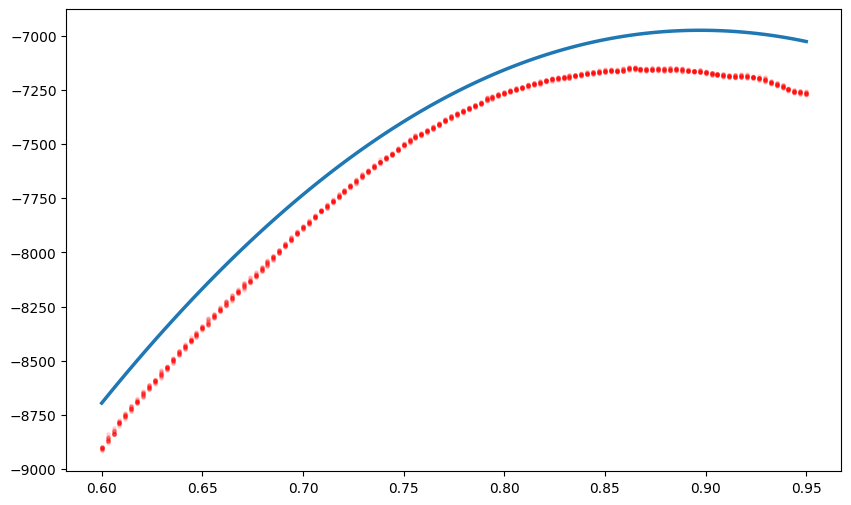

In [12]:
phi_grid_cloud = np.linspace(0.6, 0.95, 120)
seeds_cloud = np.arange(30)
N_cloud = 3000

# exact
ll_exact_cloud = np.array([exact_filter.log_likelihood(phi=p, nu=nu, c=c) for p in phi_grid_cloud])

plt.figure(figsize=(10,6))
plt.plot(phi_grid_cloud, ll_exact_cloud, linewidth=2.5, label="Exact filter")

for seed in seeds_cloud:
    pf = ParticleFilterRNG(y, N_particles=N_cloud, seed=int(seed), ess_threshold=0.5)
    ll = np.array([pf.log_likelihood(phi=p, nu=nu, c=c) for p in phi_grid_cloud])
    plt.scatter(phi_grid_cloud, ll, s=6, alpha=0.12, color="red")

plt.axvline(TRUE_PARAMS["phi"], linestyle=":", linewidth=2, label=f"True phi ({TRUE_PARAMS['phi']})")
plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Figure 1 — Exact vs Particle Filter (Monte Carlo cloud)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
